Example from here:
https://github.com/nathanmargaglio/Deep-Q-Network

Nathan Margaglio

# Deep Q-Network

## Build a Deterministic Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import copy
import threading
import time
import collections

In [2]:
det_state_trans = []
for x in range(3):
    state_x = []
    for y in range(3):
        state_y = []
        for a in range(4):
            one_hot = np.zeros(4)
            one_hot[a] = 1
            state_y.append(one_hot)
        state_x.append(state_y)
    det_state_trans.append(state_x)


def get_transition_func(transition_matrix):
    def transition_func(x, y, action, return_probs=False):
        probs = transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    return transition_func

In [3]:
det_state_trans[0][0][0]
# f = get_transition_func(det_state_trans)
# f(x, y, action)
# probs = det_state_trans[x][y][action]
# probs

array([1., 0., 0., 0.])

In [4]:
class GridEnvironment(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, transition_func, normalize=False):
        self.observation_space = gym.spaces.Box(0, 2, (2,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = 5
        self.transition_func = transition_func
        self.normalize = normalize

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])

    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [2, 2]
        self.state = np.zeros((3, 3))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)

    def step(self, action):
        action_taken = self.transition_func(
            self.agent_pos[0], self.agent_pos[1], action
        )
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 2)
        self.state = np.zeros((3, 3))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5

        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance

        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}

        obs = self.agent_pos
        if self.normalize:
            obs = obs / 2.0
        return obs, reward, done, info

    def render(self, mode="human"):
        plt.imshow(self.state)

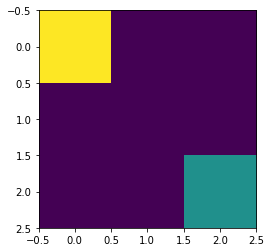

In [5]:
env = GridEnvironment(get_transition_func(det_state_trans))
obs = env.reset()
env.render()

## Implement Tabular Method

In [6]:
class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.1, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.q_table = np.zeros((3, 3, 4))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def step(self, observation):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space.n)
        else:
            return np.argmax(self.q_table[observation[0], observation[1]])

    def update(self, state, action, reward, next_state):
        self.q_table[state[0], state[1], action] = self.q_table[
            state[0], state[1], action
        ] + self.lr * (
            reward
            + self.gamma * np.max(self.q_table[next_state[0], next_state[1]])
            - self.q_table[state[0], state[1], action]
        )

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

#### Training

In [7]:
env = GridEnvironment(get_transition_func(det_state_trans))
agent = QLearningAgent(env)
episodes = 1000
# delta_epsilon = agent.epsilon / episodes

total_rewards = []
epsilons = [agent.epsilon]

for episode in range(episodes):
    obs = env.reset()
    done = False
    epsilons.append(agent.epsilon)
    total_reward = 0

    while not done:
        action = agent.step(obs)
        state = obs.copy()
        obs, reward, done, info = env.step(action)
        total_reward += reward
        next_state = obs.copy()
        agent.update(state, action, reward, next_state)

    agent.set_epsilon(agent.epsilon - (5 / episodes) * agent.epsilon)
    total_rewards.append(total_reward)

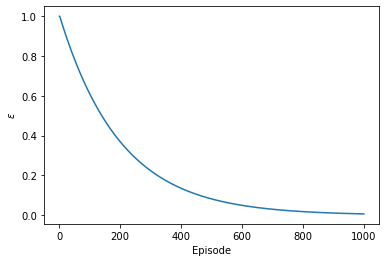

In [8]:
plt.xlabel("Episode")
plt.ylabel("$\epsilon$")
plt.plot(epsilons)

Next, we plot total_rewards per episode.  We apply a rolling mean of window $10$ to visualize easier.

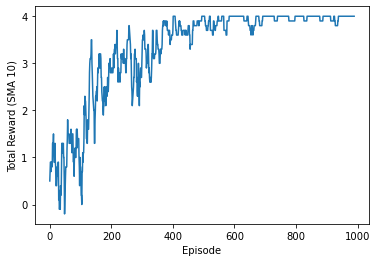

In [9]:
window = 10
plt.xlabel("Episode")
plt.ylabel("Total Reward (SMA 10)")
plt.plot(
    [
        np.mean(total_rewards[tr : tr + window])
        for tr in range(window, len(total_rewards))
    ]
)

## TensorFlow

Next, we wish to replace our tabular representation with a neural network.  We use the TensorFlow library to facilitate this.  The following cells demonstrates how TensorFlow can be used to build a neural network to properly classify XOR data (a non-linearly separable problem).

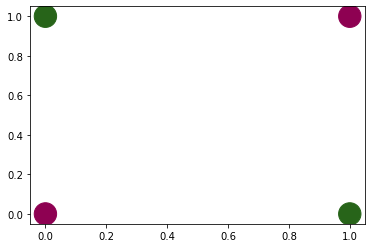

In [9]:
# XOR
input_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

output_data = np.array([[0], [1], [1], [0]])

plt.scatter(input_data[:, 0], input_data[:, 1], c=output_data.T[0], cmap="PiYG", s=500)

In [10]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

tf.enable_eager_execution()

In [11]:
class MLP(keras.Model):
    def __init__(self, observation_size, action_size):
        super(MLP, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size

        self.value_dense_1 = layers.Dense(128, activation="relu")
        self.value_dense_2 = layers.Dense(128, activation="relu")
        self.values = layers.Dense(self.action_size)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        y = self.value_dense_1(input_tensor)
        y = self.value_dense_2(y)
        values = self.values(y)
        return values

In [12]:
mlp = MLP(len(input_data[0]), len(output_data[0]))

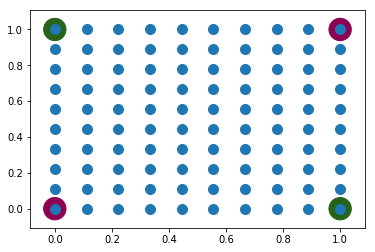

In [13]:
x_range = []
y_range = []
for ix, x in enumerate(np.linspace(0, 1, 10)):
    for iy, y in enumerate(np.linspace(0, 1, 10)):
        x_range.append(x)
        y_range.append(y)

test_data = np.column_stack((x_range, y_range))

plt.scatter(input_data[:, 0], input_data[:, 1], c=output_data.T[0], cmap="PiYG", s=500)
plt.scatter(x_range, y_range, s=100, cmap="PiYG")
plt.show()

This is the results from our untrained neural network.  Notice how the colors of the smaller dots (our neural network's predictions) don't match the colors of the larger dots (the actual class colors of our XOR data).

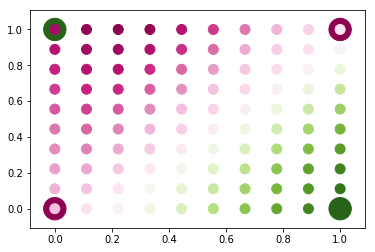

In [14]:
pred_data = mlp(test_data).numpy().flatten()

plt.scatter(input_data[:, 0], input_data[:, 1], s=500, c=output_data.T[0], cmap="PiYG")
plt.scatter(x_range, y_range, s=100, c=pred_data, cmap="PiYG")
plt.show()

The following loop will train our neural network.

In [15]:
lr = 0.1
epochs = 100
losses = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        values = mlp(input_data)
        loss = -tf.reduce_sum((output_data - values) ** 2)

    losses.append(float(loss))
    grads = tape.gradient(loss, mlp.trainable_weights)
    for w, g in zip(mlp.trainable_weights, grads):
        w.assign_add(lr * g)

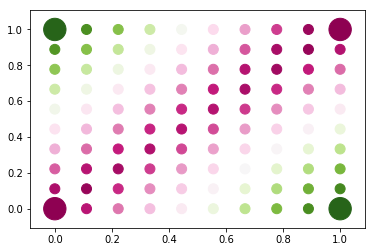

In [16]:
pred_data = mlp(test_data).numpy().flatten()

plt.scatter(input_data[:, 0], input_data[:, 1], s=500, c=output_data.T[0], cmap="PiYG")
plt.scatter(x_range, y_range, s=100, c=pred_data, cmap="PiYG")
plt.show()

## Deep Q-Learning

With our task setup and deep learning introduced, we can build our Deep Q-Network Agent.  This class is an adaptation of our previous Q-Agent class, with extra functionality introduced to facilitate training.

In [17]:
class DQNAgent:
    def __init__(
        self, env, epsilon=1.0, epsilon_min=0.02, lr=5e-4, gamma=0.99, memory_limit=1024
    ):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.lr = lr
        self.gamma = gamma
        self.memory = collections.deque([], memory_limit)
        self.memory_limit = memory_limit

        try:
            model_input_dim = self.observation_space.n
            model_input_shape = (self.observation_space.n, 1)
        except AttributeError as e:
            model_input_dim = self.observation_space.shape[0]
            model_input_shape = self.observation_space.shape

        self.model = MLP(model_input_dim, self.action_space.n)
        self.model(
            tf.convert_to_tensor(
                [np.random.normal(size=model_input_shape)], dtype=tf.float64
            )
        )

        self.target_model = MLP(model_input_dim, self.action_space.n)
        self.target_model(
            tf.convert_to_tensor(
                [np.random.normal(size=model_input_shape)], dtype=tf.float64
            )
        )

    def step(self, observation, verbose=False):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space.n)
        else:
            state_tensor = tf.convert_to_tensor([observation], dtype=tf.float64)
            q_vals = self.model(state_tensor)
            if verbose:
                print(q_vals[0])
            return np.argmax(q_vals[0])

    def collect(self, state, action, reward, done, next_state):
        self.memory.append((state, action, reward, done, next_state))

    def sample(self, size):
        sample_index = np.random.choice(len(self.memory), size=size, replace=True)

        states = []
        actions = []
        rewards = []
        dones = []
        next_states = []
        for idx in sample_index:
            unit = self.memory[idx]
            states.append(unit[0])
            actions.append(unit[1])
            rewards.append(unit[2])
            dones.append(unit[3])
            next_states.append(unit[4])
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(dones),
            np.array(next_states),
        )

    def train(self, epochs=10, batch_size=128, verbose=False):
        losses = []
        for epoch in range(epochs):
            states, actions, rewards, dones, next_states = self.sample(batch_size)
            states = tf.convert_to_tensor(states, dtype=tf.float64)
            done_masks = tf.convert_to_tensor(
                (~dones.astype(bool)).astype(int), dtype=tf.float64
            )
            next_states = tf.convert_to_tensor(next_states, dtype=tf.float64)
            action_masks = tf.one_hot(actions, self.action_space.n, dtype=tf.float64)
            target_values = tf.expand_dims(
                rewards
                + self.gamma * np.max(self.target_model(next_states)) * done_masks,
                axis=1,
            )
            target_values *= action_masks
            with tf.GradientTape() as tape:
                q_values = self.model(states) * action_masks
                if verbose:
                    print(target_values, q_values)
                loss = tf.reduce_mean((target_values - q_values) ** 2)

            losses.append(loss)
            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer = tf.train.AdamOptimizer(self.lr)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return np.mean(losses)

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min

With our agent defined, we can train it on the environment we built.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


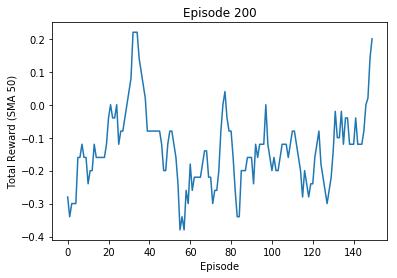

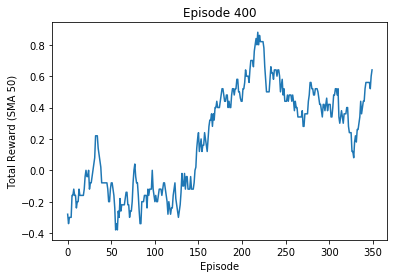

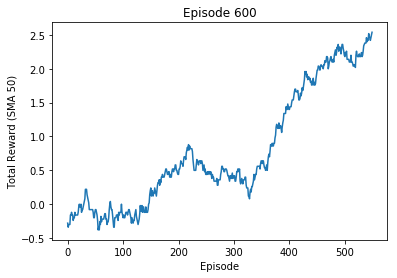

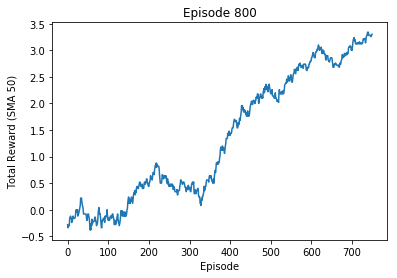

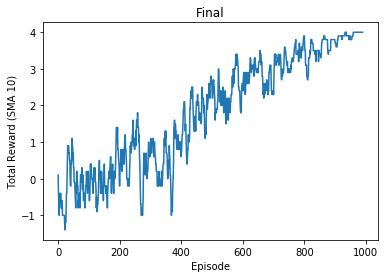

Parallel Training Complete.


In [18]:
env = GridEnvironment(get_transition_func(det_state_trans), normalize=True)
agent = DQNAgent(env, lr=0.001, gamma=0.5)

episodes = 1000
training_batch_size = 32
epochs = 10
delta_epsilon = agent.epsilon / episodes

episode = 0


def train_agent():
    train_step = 0
    while episode < episodes - 1:
        if len(agent.memory) >= training_batch_size:
            train_step += 1
            agent.train(epochs, training_batch_size)
            if train_step % 50 == 0:
                agent.update_target()
    print("Parallel Training Complete.")


try:
    p1.join()
except:
    pass
p1 = threading.Thread(target=train_agent)
p1.start()

total_rewards = []
epsilons = [agent.epsilon]

step = 0
for episode in range(episodes):
    obs = env.reset()
    done = False
    epsilons.append(agent.epsilon)
    total_reward = 0
    last_target_update = 0

    # print(f'Episode: {episode}')
    while not done:
        action = agent.step(obs)
        state = obs.copy()
        obs, reward, done, info = env.step(action)
        total_reward += reward
        next_state = obs.copy()
        agent.collect(state, action, reward, done, next_state)
        step += 1

    if episode % (episodes // 5) == 0 and episode > 0:
        window = 50
        plt.title("Episode {}".format(episode))
        plt.xlabel("Episode")
        plt.ylabel("Total Reward (SMA {})".format(window))
        plt.plot(
            [
                np.mean(total_rewards[tr : tr + window])
                for tr in range(len(total_rewards) - window)
            ]
        )
        plt.show()

    agent.set_epsilon(agent.epsilon - delta_epsilon)
    total_rewards.append(total_reward)

window = 10
plt.title("Final")
plt.xlabel("Episode")
plt.ylabel("Total Reward (SMA {})".format(window))
plt.plot(
    [
        np.mean(total_rewards[tr : tr + window])
        for tr in range(len(total_rewards) - window)
    ]
)
plt.show()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


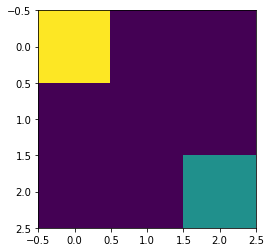

tf.Tensor([ 0.63407003 -0.65647415  1.00743481 -0.63589331], shape=(4,), dtype=float64)


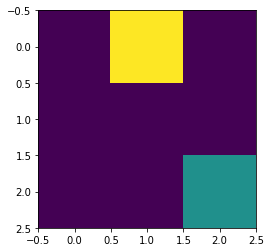

tf.Tensor([ 0.99954647 -0.79179145  0.86502867 -0.84954549], shape=(4,), dtype=float64)


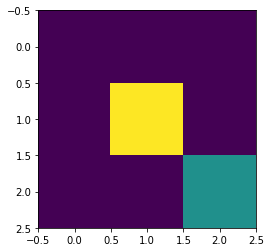

tf.Tensor([ 0.80478743 -0.97439052  1.06423397 -0.9485818 ], shape=(4,), dtype=float64)


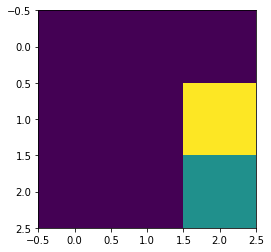

tf.Tensor([ 1.1005514  -1.15272373  0.90672973 -1.14455366], shape=(4,), dtype=float64)


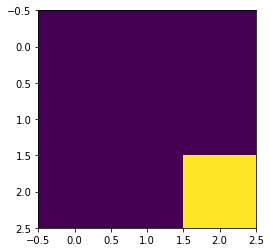

In [19]:
env = GridEnvironment(get_transition_func(det_state_trans), normalize=True)
# agent = DQNAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

# 0 - down
# 1 - up
# 2 - right
# 3 - left

## Apply DQN to OpenAI Gym Environments

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


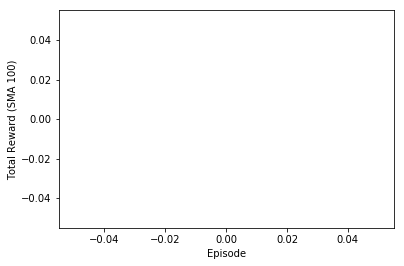

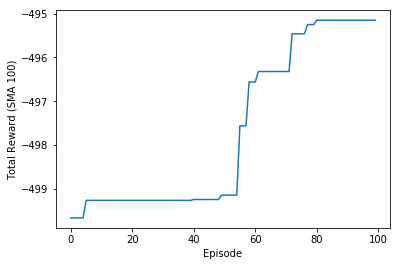

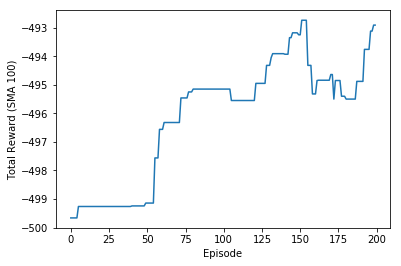

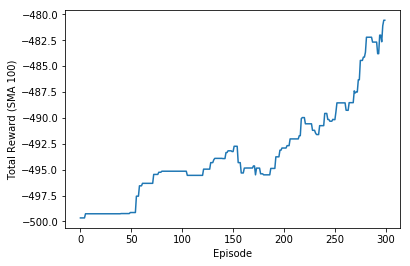

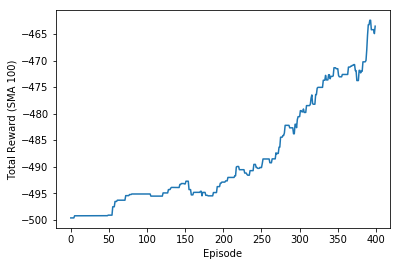

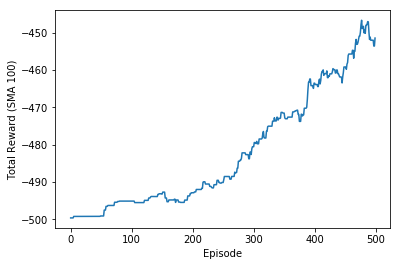

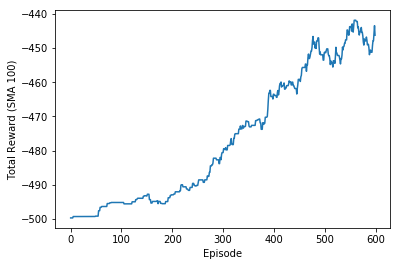

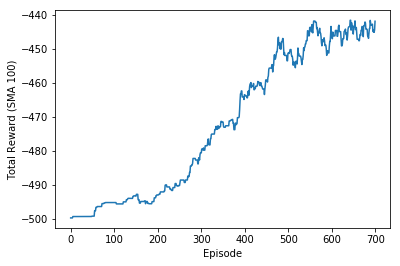

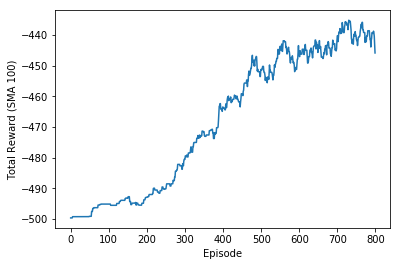

Training Stopped


In [27]:
import multiprocessing as mp

env = gym.envs.make("Acrobot-v1")
agent_a = DQNAgent(env)

episodes = 1000
training_batch_size = 32
epochs = 1
delta_epsilon = agent_a.epsilon / episodes

manager = mp.Manager()
shared = manager.Value("episode", 0)


def train_agent(shared):
    train_step = 0
    while shared.get() < episodes - 1:
        if len(agent_a.memory) >= training_batch_size:
            train_step += 1
            agent_a.train(epochs, training_batch_size)
            if train_step % 50 == 0:
                agent_a.update_target()
    print("Training Stopped")


p2 = mp.Process(target=train_agent, args=(shared,))
p2.start()

total_rewards_a = []
epsilons_a = [agent_a.epsilon]

step = 0
for episode in range(episodes):
    obs = env.reset()
    done = False
    epsilons_a.append(agent_a.epsilon)
    total_reward = 0
    last_target_update = 0

    # print(f'Episode: {episode}')
    while not done:
        action = agent_a.step(obs)
        state = obs.copy()
        obs, reward, done, info = env.step(action)
        total_reward += reward
        next_state = obs.copy()
        agent_a.collect(state, action, reward, done, next_state)
        step += 1

    shared.set(episode)

    if episode % (episodes // 10) == 0 and episode > 0:
        window = 100
        plt.xlabel("Episode")
        plt.ylabel("Total Reward (SMA {})".format(window))
        plt.plot(
            [
                np.mean(total_rewards_a[tr : tr + window])
                for tr in range(len(total_rewards_a) - window)
            ]
        )
        plt.show()

    agent_a.set_epsilon(agent_a.epsilon - delta_epsilon)
    total_rewards_a.append(total_reward)

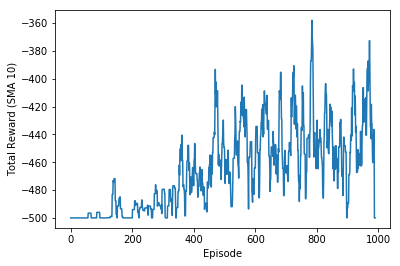

In [28]:
window = 10
plt.xlabel("Episode")
plt.ylabel("Total Reward (SMA 10)")
plt.plot(
    [
        np.mean(total_rewards_a[tr : tr + window])
        for tr in range(window, len(total_rewards_a))
    ]
)